# Setup

In [5]:
import numpy as np
import os
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from itertools import combinations
from pathlib import Path
from typing import List, Dict, Any
from ranker import ScoreRanker

In [6]:
BASE_ARTIFACT_DIR = Path("/vol/bitbucket/hrm20/fyp/artifacts/")
BASE_OUTPUT_DIR = Path("/vol/bitbucket/hrm20/fyp/analysis/")
SUMMARY_FILENAME = "training_dynamics_summary.pkl"

DATASETS = ["FEVER", "QQP", "MNLI"]
MODEL_FAMILIES = ["bert", "roberta", "xlnet"]
MODEL_SIZES = ["base", "large"]
ALL_METRICS = ['aum', 'datamap', 'el2n', 'loss', 'forgetting', 'accuracy', 'grand']

FIG_DPI = 300

In [7]:
def get_ranks_from_sorted_indices(sorted_indices: np.ndarray) -> np.ndarray:
    """Converts an array of sorted data indices into a rank array."""
    if sorted_indices.size == 0:
        return np.array([])
    ranks = np.empty_like(sorted_indices)
    ranks[sorted_indices] = np.arange(len(sorted_indices))
    return ranks

def load_stats_from_directory(directory: Path) -> List[Dict]:
    """Loads all run statistics from .pkl files in a given directory."""
    stats_list = []
    if not directory.is_dir():
        print(f"Warning: Directory not found at {directory}. Skipping.")
        return stats_list
    for i in range(1, 11):
        file_path = directory / f"run{i}.pkl"
        if file_path.exists():
            with open(file_path, "rb") as f:
                eval_summary = pickle.load(f)
                stats_list.append(eval_summary["raw_scores"])
    return stats_list

def create_plot(df: pd.DataFrame, plot_type: str, title: str, filename: Path, **kwargs: Any) -> None:
    """Generic plot generator for heatmaps and bar plots."""
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=kwargs.get("figsize", (13, 7)))

    if df.empty:
        ax.text(0.5, 0.5, "No data to plot.", ha='center', va='center')
    elif plot_type == 'heatmap':
        sns.heatmap(df, annot=True, fmt=".2f", cmap=kwargs.get("palette"), vmin=kwargs.get("vmin"), vmax=kwargs.get("vmax"), ax=ax, annot_kws={"size": 14})
        ax.set_xticklabels(df.columns, rotation=45, ha="right")
        ax.set_yticklabels(df.index, rotation=0)
    elif plot_type == 'barplot':
        sns.barplot(data=df, x='Metric', y='Correlation', hue='Group', palette=kwargs.get("palette"), ax=ax)
        ax.set_ylabel(r"Spearman's Correlation ($\rho$)", fontsize=18)
        ax.set_xlabel("Hardness Metric", fontsize=18)
        ax.tick_params(axis='x', rotation=45, labelsize=16)
        ax.tick_params(axis='y', labelsize=16)
        ax.legend(title=kwargs.get("hue_title"), title_fontsize=16, loc='upper left', bbox_to_anchor=(1.01, 1), fontsize=14)
        plt.subplots_adjust(right=0.80)

    ax.set_title(title, fontsize=20, pad=20)
    filename.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(filename, dpi=FIG_DPI, bbox_inches='tight')
    plt.close(fig)
    print(f"Plot saved to {filename}")


In [8]:
def _get_average_final_ranks(stats_list: List[Dict], metrics: List[str]) -> Dict[str, np.ndarray]:
    """Calculates the average final-epoch ranks across multiple runs."""
    all_ranks = {metric: [] for metric in metrics}
    for stats in stats_list:
        ranker = ScoreRanker(stats) 
        ranked_indices = ranker.get_ranked_indices()
        for metric in metrics:
            if ranked_indices.get(metric):
                final_indices = ranked_indices[metric][-1]
                if len(final_indices) > 0:
                    all_ranks[metric].append(get_ranks_from_sorted_indices(final_indices))
    avg_ranks = {}
    for metric, ranks_list in all_ranks.items():
        if ranks_list:
            avg_ranks[metric] = np.mean(np.vstack(ranks_list), axis=0)
    return avg_ranks

def _get_cross_seed_correlations(stats_list: List[Dict], metrics: List[str]) -> Dict[str, List[float]]:
    """Computes pairwise Spearman correlations across seeds for each metric."""
    corrs = {metric: [] for metric in metrics}
    ranks_by_metric = {m: [] for m in metrics}
    for stats in stats_list:
        ranker = ScoreRanker(stats)
        ranked_indices = ranker.get_ranked_indices()
        for metric in metrics:
            if ranked_indices.get(metric):
                final_indices = ranked_indices[metric][-1]
                if len(final_indices) > 0:
                    ranks_by_metric[metric].append(get_ranks_from_sorted_indices(final_indices))
    for metric, ranks in ranks_by_metric.items():
        if len(ranks) >= 2:
            for r1, r2 in combinations(ranks, 2):
                corr, _ = spearmanr(r1, r2)
                if not np.isnan(corr):
                    corrs[metric].append(corr)
    return corrs

def create_summary_file() -> None:
    """
    Calculates average ranks and cross-seed correlations for all experiments
    and saves the results to a single summary file.
    """
    print("--- Starting pre-processing to create summary file ---")
    results = {"avg_ranks": {}, "cross_seed_corrs": {}}
    summary_path = BASE_OUTPUT_DIR / SUMMARY_FILENAME
    for ds in DATASETS:
        results["avg_ranks"][ds] = {}
        results["cross_seed_corrs"][ds] = {}
        for family in MODEL_FAMILIES:
            for size in MODEL_SIZES:
                model_key = f"{family}_{size}"
                model_path = BASE_ARTIFACT_DIR / f"{model_key}_{ds.lower()}/"
                print(f"Processing: {model_key} on {ds}...")
                stats_list = load_stats_from_directory(model_path)
                if not stats_list: continue
                # This logic correctly excludes 'grand' for non-roberta models
                metrics_to_use = ALL_METRICS if family == 'roberta' else [m for m in ALL_METRICS if m != 'grand']
                results["avg_ranks"][ds][model_key] = _get_average_final_ranks(stats_list, metrics_to_use)
                results["cross_seed_corrs"][ds][model_key] = _get_cross_seed_correlations(stats_list, metrics_to_use)
    summary_path.parent.mkdir(exist_ok=True)
    with open(summary_path, "wb") as f: pickle.dump(results, f)
    print(f"Pre-processing complete. Data saved to '{summary_path}'")

# Research Question 1

In [9]:
def generate_rq1_correlation_heatmaps(model_path: Path, title_name: str, output_dir: Path, metrics: List[str], model_key: str, dataset: str) -> None:
    """Analyzes and plots metric correlation heatmaps (RQ1)."""
    print(f"  -> Generating RQ1 plots for {title_name}")
    stats_list = load_stats_from_directory(model_path)
    if not stats_list: return

    all_run_matrices = []
    method_names_in_data = [] 

    for stats in stats_list:
        ranker = ScoreRanker(stats)
        ranked_indices = {k: v for k, v in ranker.get_ranked_indices().items() if k in metrics}
        if not ranked_indices: continue
        
        method_names_in_data = list(ranked_indices.keys())
        num_epochs = len(next(iter(ranked_indices.values()), []))
        epoch_corr_matrices = []

        for epoch in range(num_epochs):
            epoch_ranks = {method: get_ranks_from_sorted_indices(indices[epoch]) for method, indices in ranked_indices.items()}
            ranks_df = pd.DataFrame(epoch_ranks)
            if not ranks_df.empty:
                epoch_corr_matrices.append(ranks_df.corr(method='spearman').to_numpy())
        if epoch_corr_matrices:
            all_run_matrices.append(np.nanmean(epoch_corr_matrices, axis=0))

    if not all_run_matrices: return
    
    avg_matrix = pd.DataFrame(np.nanmean(all_run_matrices, axis=0), index=method_names_in_data, columns=method_names_in_data)
    std_matrix = pd.DataFrame(np.nanstd(all_run_matrices, axis=0), index=method_names_in_data, columns=method_names_in_data)
    
    rq1_figsize = (12, 10)
    
    avg_filename = output_dir / f"{model_key}_{dataset.lower()}_rq1_avg_correlation.png"
    std_filename = output_dir / f"{model_key}_{dataset.lower()}_rq1_std_correlation.png"
    
    create_plot(avg_matrix, 'heatmap', f"Average Metric Correlation\n({title_name})", avg_filename, palette="vlag", vmin=-1, vmax=1, figsize=rq1_figsize)
    create_plot(std_matrix, 'heatmap', f"Std. Dev. of Metric Correlation\n({title_name})", std_filename, palette="viridis_r", vmin=0, vmax=0.25, figsize=rq1_figsize)


# Research Question 2

In [10]:
def generate_rq2_plots(all_ranks: Dict, output_dir: Path) -> None:
    """Generates all consistency plots for RQ2."""
    print("  -> Generating RQ2 plots")
    
    # --- RQ2.1: Cross-Scale Consistency ---
    for family in MODEL_FAMILIES:
        plot_data = []
        for ds in DATASETS:
            base_ranks = all_ranks.get(ds, {}).get(f"{family}_base", {})
            large_ranks = all_ranks.get(ds, {}).get(f"{family}_large", {})
            
            # Find all common metrics first
            metrics_to_plot = list(base_ranks.keys() & large_ranks.keys())
            
            # Filter 'grand' if experiment is not roberta
            if family != 'roberta' and 'grand' in metrics_to_plot:
                metrics_to_plot.remove('grand')

            for metric in metrics_to_plot:
                corr, _ = spearmanr(base_ranks[metric], large_ranks[metric])
                plot_data.append({'Group': ds, 'Metric': metric, 'Correlation': corr if not np.isnan(corr) else 0.0})
        
        df = pd.DataFrame(plot_data)
        create_plot(df, 'barplot', f'{family.upper()} Consistency (Base vs. Large)', output_dir / f'rq2.1_cross_scale_{family}.png', palette="YlGnBu", hue_title='Dataset')

    # --- RQ2.2: Cross-Architecture Consistency ---
    for ds in DATASETS:
        plot_data = []
        for fam1, fam2 in combinations(MODEL_FAMILIES, 2):
            ranks1 = all_ranks.get(ds, {}).get(f"{fam1}_base", {})
            ranks2 = all_ranks.get(ds, {}).get(f"{fam2}_base", {})
            
            metrics_to_plot = list(ranks1.keys() & ranks2.keys())
            if (fam1 != 'roberta' or fam2 != 'roberta') and 'grand' in metrics_to_plot:
                metrics_to_plot.remove('grand')

            for metric in metrics_to_plot:
                corr, _ = spearmanr(ranks1[metric], ranks2[metric])
                plot_data.append({'Group': f"{fam1.upper()} vs {fam2.upper()}", 'Metric': metric, 'Correlation': corr if not np.isnan(corr) else 0.0})
        
        df = pd.DataFrame(plot_data)
        create_plot(df, 'barplot', f'Cross-Architecture Consistency on {ds} (Base Models)', output_dir / f'rq2.2_cross_arch_{ds.lower()}.png', palette="Greens", hue_title='Comparison')

# Research Question 3

In [11]:
def generate_rq3_plots(model_name: str, dataset: str, output_dir: Path, cross_seed_data: Dict, metrics_for_rq3: List[str]) -> None:
    """Generates all stability plots for RQ3 using the original styling and correct filtering."""
    print(f"  -> Generating RQ3 plots for {model_name} on {dataset}")
    
    # --- RQ3.1: Seed Stability (Bar Plot) ---
    stability_scores = {
        metric: np.mean(corrs) 
        for metric, corrs in cross_seed_data.items() 
        if corrs and metric in metrics_for_rq3
    }
    
    if stability_scores:
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, ax = plt.subplots(figsize=(10, 6))
        
        labels = list(stability_scores.keys())
        values = list(stability_scores.values())
        
        sns.barplot(x=labels, y=values, palette="viridis", width=0.6, ax=ax)
        
        ax.set_title(f'Metric Stability Across Random Seeds\n({model_name.replace("_", "-").title()} on {dataset})', fontsize=16, pad=20)
        ax.set_ylabel(r"Average Pairwise Spearman's Correlation ($\rho$)", fontsize=12)
        ax.set_xlabel("Hardness Metric", fontsize=12)
        ax.set_ylim(0, 1.05)
        ax.tick_params(axis='x', rotation=45)
        
        for i, v in enumerate(values):
            ax.text(i, v + 0.02, f"{v:.2f}", ha='center', color='black')
        
        filename = output_dir / f"{model_name}_{dataset.lower()}_rq3_1_seed_stability.png"
        filename.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(filename, dpi=FIG_DPI, bbox_inches='tight')
        plt.close(fig)
        print(f"Plot saved to {filename}")

    # --- RQ3.2: Epoch Stability (Line Plot) ---
    model_path = BASE_ARTIFACT_DIR / f"{model_name}_{dataset.lower()}/"
    stats_list = load_stats_from_directory(model_path)
    if not stats_list: return

    ranker = ScoreRanker(stats_list[0])
    ranked_indices = ranker.get_ranked_indices()
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))
    epochs = np.array([])
    
    for metric in metrics_for_rq3:
        if ranked_indices.get(metric):
            epoch_ranks_list = [get_ranks_from_sorted_indices(e) for e in ranked_indices[metric]]
            if not epoch_ranks_list: continue
            
            final_ranks = epoch_ranks_list[-1]
            correlations = [spearmanr(epoch_ranks, final_ranks).correlation for epoch_ranks in epoch_ranks_list]
            epochs = np.arange(1, len(correlations) + 1)
            sns.lineplot(x=epochs, y=correlations, label=metric.capitalize(), marker='o', markersize=7, lw=2.5, ax=ax)

    if epochs.size > 0:
        ax.set_title(f'Metric Stability Across Epochs\n({model_name.replace("_", "-").title()} on {dataset})', fontsize=16, pad=20)
        ax.set_xlabel("Epoch", fontsize=12)
        ax.set_ylabel(r"Spearman's Correlation ($\rho$) vs. Final Epoch Rank", fontsize=12)
        ax.legend(title="Metric")
        ax.grid(True, which='both', linestyle='--')
        ax.set_xticks(epochs)
        
        filename = output_dir / f"{model_name}_{dataset.lower()}_rq3_2_epoch_stability.png"
        filename.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(filename, dpi=FIG_DPI, bbox_inches='tight')
        
    plt.close(fig)
    if epochs.size > 0:
        print(f"Plot saved to {filename}")

# Summary

In [12]:
def generate_summary_plots(all_ranks: Dict, cross_seed_corrs: Dict, output_dir: Path) -> None:
    """
    Aggregates consistency scores across all experiments (excluding 'grand') 
    and generates summary plots.
    """
    print("\n--- Generating final summary plots ---")
    metrics_for_summary = [m for m in ALL_METRICS if m != 'grand']

    # 1. Aggregate scores from all experiments into three categories
    summary_scores = {
        'Cross-Seed': {m: [] for m in metrics_for_summary},
        'Cross-Scale': {m: [] for m in metrics_for_summary},
        'Cross-Architecture': {m: [] for m in metrics_for_summary}
    }

    # --- Aggregate Cross-Seed scores ---
    for ds_data in cross_seed_corrs.values():
        for model_data in ds_data.values():
            for metric, corrs in model_data.items():
                if metric in summary_scores['Cross-Seed']:
                    summary_scores['Cross-Seed'][metric].extend(corrs)

    # --- Aggregate Cross-Scale scores ---
    for ds in DATASETS:
        for family in MODEL_FAMILIES:
            base = all_ranks.get(ds, {}).get(f"{family}_base", {})
            large = all_ranks.get(ds, {}).get(f"{family}_large", {})
            for metric in base.keys() & large.keys():
                if metric in summary_scores['Cross-Scale']:
                    corr, _ = spearmanr(base[metric], large[metric])
                    if not np.isnan(corr):
                        summary_scores['Cross-Scale'][metric].append(corr)

    # --- Aggregate Cross-Architecture scores ---
    for ds in DATASETS:
        for fam1, fam2 in combinations(MODEL_FAMILIES, 2):
            ranks1 = all_ranks.get(ds, {}).get(f"{fam1}_base", {})
            ranks2 = all_ranks.get(ds, {}).get(f"{fam2}_base", {})
            for metric in ranks1.keys() & ranks2.keys():
                if metric in summary_scores['Cross-Architecture']:
                    corr, _ = spearmanr(ranks1[metric], ranks2[metric])
                    if not np.isnan(corr):
                        summary_scores['Cross-Architecture'][metric].append(corr)

    # Filter out metrics that have no data to prevent errors
    filtered_summary_scores = {
        category: {metric: scores for metric, scores in data.items() if scores}
        for category, data in summary_scores.items()
    }
    
    if not any(filtered_summary_scores.values()):
        print("No data available for summary plots. Skipping.")
        return

    # 2. Generate Plot 1: Overall summary bar chart
    labels = list(filtered_summary_scores.keys())
    palette = sns.color_palette("YlGnBu", n_colors=len(labels))

    mean_scores = [
        np.mean([s for scores in filtered_summary_scores[label].values() for s in scores])
        for label in labels
    ]

    plt.figure(figsize=(8, 4))
    bars = plt.bar(labels, mean_scores, color=palette)
    plt.ylabel("Average Spearman Correlation", fontsize=14)
    plt.title("Consistency of Training Dynamics", fontsize=15)
    plt.ylim(0, 1)

    for bar in bars:
        h = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, h + 0.015, f"{h:.2f}", ha="center", fontsize=12)

    plt.tight_layout()
    plt.savefig(output_dir / "summary_overall_consistency.png", dpi=FIG_DPI)
    plt.show()

    # 3. Generate Plot 2: Per-metric grouped bar chart
    metrics_to_plot = list(next(iter(filtered_summary_scores.values())).keys())
    x = np.arange(len(metrics_to_plot))
    width = 0.25

    plt.figure(figsize=(14, 6))
    for i, (label, color) in enumerate(zip(labels, palette)):
        means = [np.mean(filtered_summary_scores[label].get(m, [0])) for m in metrics_to_plot]
        plt.bar(x + i * width, means, width=width, label=label, color=color)

    plt.xticks(x + width * (len(labels) - 1) / 2, metrics_to_plot, rotation=45, fontsize=12)
    plt.ylim(0, 1)
    plt.ylabel("Average Spearman Correlation", fontsize=14)
    plt.title("Per-Metric Consistency Across Experiments", fontsize=16)
    plt.legend(loc="upper left", bbox_to_anchor=(1.01, 1), fontsize=12)
    plt.subplots_adjust(right=0.85)
    plt.tight_layout()
    plt.savefig(output_dir / "summary_per_metric_consistency.png", dpi=FIG_DPI)
    plt.show()

# Run


--- Loading pre-processed data from '/vol/bitbucket/hrm20/fyp/analysis/training_dynamics_summary.pkl' ---

--- Generating all analysis plots ---
  -> Generating RQ2 plots
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ2/rq2.1_cross_scale_bert.png
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ2/rq2.1_cross_scale_roberta.png
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ2/rq2.1_cross_scale_xlnet.png
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ2/rq2.2_cross_arch_fever.png
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ2/rq2.2_cross_arch_qqp.png
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ2/rq2.2_cross_arch_mnli.png
  -> Generating RQ1 plots for Bert-Base on FEVER
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ1/bert_base_fever_rq1_avg_correlation.png
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ1/bert_base_fever_rq1_std_correlation.png
  -> Generating RQ3 plots for bert_base on FEVER


/tmp/ipykernel_3987033/2227277631.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette="viridis", width=0.6, ax=ax)


Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ3/bert_base_fever_rq3_1_seed_stability.png
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ3/bert_base_fever_rq3_2_epoch_stability.png
  -> Generating RQ1 plots for Bert-Large on FEVER
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ1/bert_large_fever_rq1_avg_correlation.png
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ1/bert_large_fever_rq1_std_correlation.png
  -> Generating RQ3 plots for bert_large on FEVER


/tmp/ipykernel_3987033/2227277631.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette="viridis", width=0.6, ax=ax)


Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ3/bert_large_fever_rq3_1_seed_stability.png
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ3/bert_large_fever_rq3_2_epoch_stability.png
  -> Generating RQ1 plots for Roberta-Base on FEVER
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ1/roberta_base_fever_rq1_avg_correlation.png
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ1/roberta_base_fever_rq1_std_correlation.png
  -> Generating RQ3 plots for roberta_base on FEVER


/tmp/ipykernel_3987033/2227277631.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette="viridis", width=0.6, ax=ax)


Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ3/roberta_base_fever_rq3_1_seed_stability.png
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ3/roberta_base_fever_rq3_2_epoch_stability.png
  -> Generating RQ1 plots for Roberta-Large on FEVER
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ1/roberta_large_fever_rq1_avg_correlation.png
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ1/roberta_large_fever_rq1_std_correlation.png
  -> Generating RQ3 plots for roberta_large on FEVER


/tmp/ipykernel_3987033/2227277631.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette="viridis", width=0.6, ax=ax)


Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ3/roberta_large_fever_rq3_1_seed_stability.png
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ3/roberta_large_fever_rq3_2_epoch_stability.png
  -> Generating RQ1 plots for Xlnet-Base on FEVER
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ1/xlnet_base_fever_rq1_avg_correlation.png
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ1/xlnet_base_fever_rq1_std_correlation.png
  -> Generating RQ3 plots for xlnet_base on FEVER


/tmp/ipykernel_3987033/2227277631.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette="viridis", width=0.6, ax=ax)


Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ3/xlnet_base_fever_rq3_1_seed_stability.png
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ3/xlnet_base_fever_rq3_2_epoch_stability.png
  -> Generating RQ1 plots for Xlnet-Large on FEVER
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ1/xlnet_large_fever_rq1_avg_correlation.png
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ1/xlnet_large_fever_rq1_std_correlation.png
  -> Generating RQ3 plots for xlnet_large on FEVER


/tmp/ipykernel_3987033/2227277631.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette="viridis", width=0.6, ax=ax)


Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ3/xlnet_large_fever_rq3_1_seed_stability.png
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ3/xlnet_large_fever_rq3_2_epoch_stability.png
  -> Generating RQ1 plots for Bert-Base on QQP
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ1/bert_base_qqp_rq1_avg_correlation.png
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ1/bert_base_qqp_rq1_std_correlation.png
  -> Generating RQ3 plots for bert_base on QQP


/tmp/ipykernel_3987033/2227277631.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette="viridis", width=0.6, ax=ax)


Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ3/bert_base_qqp_rq3_1_seed_stability.png
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ3/bert_base_qqp_rq3_2_epoch_stability.png
  -> Generating RQ1 plots for Bert-Large on QQP
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ1/bert_large_qqp_rq1_avg_correlation.png
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ1/bert_large_qqp_rq1_std_correlation.png
  -> Generating RQ3 plots for bert_large on QQP


/tmp/ipykernel_3987033/2227277631.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette="viridis", width=0.6, ax=ax)


Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ3/bert_large_qqp_rq3_1_seed_stability.png
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ3/bert_large_qqp_rq3_2_epoch_stability.png
  -> Generating RQ1 plots for Roberta-Base on QQP
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ1/roberta_base_qqp_rq1_avg_correlation.png
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ1/roberta_base_qqp_rq1_std_correlation.png
  -> Generating RQ3 plots for roberta_base on QQP


/tmp/ipykernel_3987033/2227277631.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette="viridis", width=0.6, ax=ax)


Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ3/roberta_base_qqp_rq3_1_seed_stability.png
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ3/roberta_base_qqp_rq3_2_epoch_stability.png
  -> Generating RQ1 plots for Roberta-Large on QQP
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ1/roberta_large_qqp_rq1_avg_correlation.png
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ1/roberta_large_qqp_rq1_std_correlation.png
  -> Generating RQ3 plots for roberta_large on QQP


/tmp/ipykernel_3987033/2227277631.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette="viridis", width=0.6, ax=ax)


Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ3/roberta_large_qqp_rq3_1_seed_stability.png
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ3/roberta_large_qqp_rq3_2_epoch_stability.png
  -> Generating RQ1 plots for Xlnet-Base on QQP
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ1/xlnet_base_qqp_rq1_avg_correlation.png
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ1/xlnet_base_qqp_rq1_std_correlation.png
  -> Generating RQ3 plots for xlnet_base on QQP


/tmp/ipykernel_3987033/2227277631.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette="viridis", width=0.6, ax=ax)


Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ3/xlnet_base_qqp_rq3_1_seed_stability.png
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ3/xlnet_base_qqp_rq3_2_epoch_stability.png
  -> Generating RQ1 plots for Xlnet-Large on QQP
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ1/xlnet_large_qqp_rq1_avg_correlation.png
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ1/xlnet_large_qqp_rq1_std_correlation.png
  -> Generating RQ3 plots for xlnet_large on QQP


/tmp/ipykernel_3987033/2227277631.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette="viridis", width=0.6, ax=ax)


Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ3/xlnet_large_qqp_rq3_1_seed_stability.png
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ3/xlnet_large_qqp_rq3_2_epoch_stability.png
  -> Generating RQ1 plots for Bert-Base on MNLI
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ1/bert_base_mnli_rq1_avg_correlation.png
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ1/bert_base_mnli_rq1_std_correlation.png
  -> Generating RQ3 plots for bert_base on MNLI


/tmp/ipykernel_3987033/2227277631.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette="viridis", width=0.6, ax=ax)


Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ3/bert_base_mnli_rq3_1_seed_stability.png
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ3/bert_base_mnli_rq3_2_epoch_stability.png
  -> Generating RQ1 plots for Bert-Large on MNLI
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ1/bert_large_mnli_rq1_avg_correlation.png
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ1/bert_large_mnli_rq1_std_correlation.png
  -> Generating RQ3 plots for bert_large on MNLI


/tmp/ipykernel_3987033/2227277631.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette="viridis", width=0.6, ax=ax)


Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ3/bert_large_mnli_rq3_1_seed_stability.png
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ3/bert_large_mnli_rq3_2_epoch_stability.png
  -> Generating RQ1 plots for Roberta-Base on MNLI
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ1/roberta_base_mnli_rq1_avg_correlation.png
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ1/roberta_base_mnli_rq1_std_correlation.png
  -> Generating RQ3 plots for roberta_base on MNLI


/tmp/ipykernel_3987033/2227277631.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette="viridis", width=0.6, ax=ax)


Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ3/roberta_base_mnli_rq3_1_seed_stability.png
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ3/roberta_base_mnli_rq3_2_epoch_stability.png
  -> Generating RQ1 plots for Roberta-Large on MNLI
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ1/roberta_large_mnli_rq1_avg_correlation.png
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ1/roberta_large_mnli_rq1_std_correlation.png
  -> Generating RQ3 plots for roberta_large on MNLI


/tmp/ipykernel_3987033/2227277631.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette="viridis", width=0.6, ax=ax)


Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ3/roberta_large_mnli_rq3_1_seed_stability.png
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ3/roberta_large_mnli_rq3_2_epoch_stability.png
  -> Generating RQ1 plots for Xlnet-Base on MNLI
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ1/xlnet_base_mnli_rq1_avg_correlation.png
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ1/xlnet_base_mnli_rq1_std_correlation.png
  -> Generating RQ3 plots for xlnet_base on MNLI


/tmp/ipykernel_3987033/2227277631.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette="viridis", width=0.6, ax=ax)


Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ3/xlnet_base_mnli_rq3_1_seed_stability.png
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ3/xlnet_base_mnli_rq3_2_epoch_stability.png
  -> Generating RQ1 plots for Xlnet-Large on MNLI
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ1/xlnet_large_mnli_rq1_avg_correlation.png
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ1/xlnet_large_mnli_rq1_std_correlation.png
  -> Generating RQ3 plots for xlnet_large on MNLI


/tmp/ipykernel_3987033/2227277631.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette="viridis", width=0.6, ax=ax)


Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ3/xlnet_large_mnli_rq3_1_seed_stability.png
Plot saved to /vol/bitbucket/hrm20/fyp/analysis/RQ3/xlnet_large_mnli_rq3_2_epoch_stability.png

--- Generating final summary plots ---


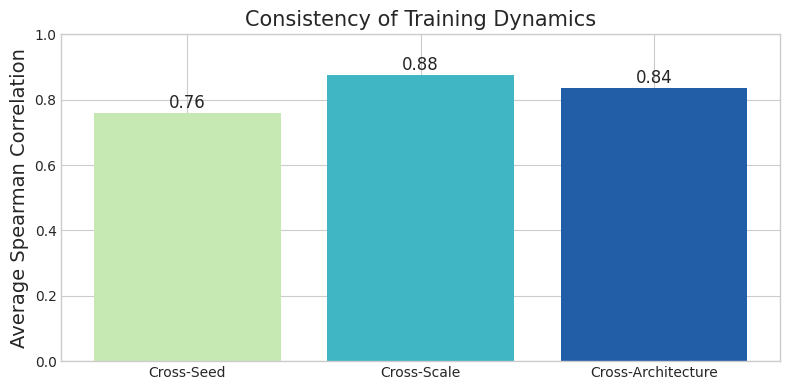

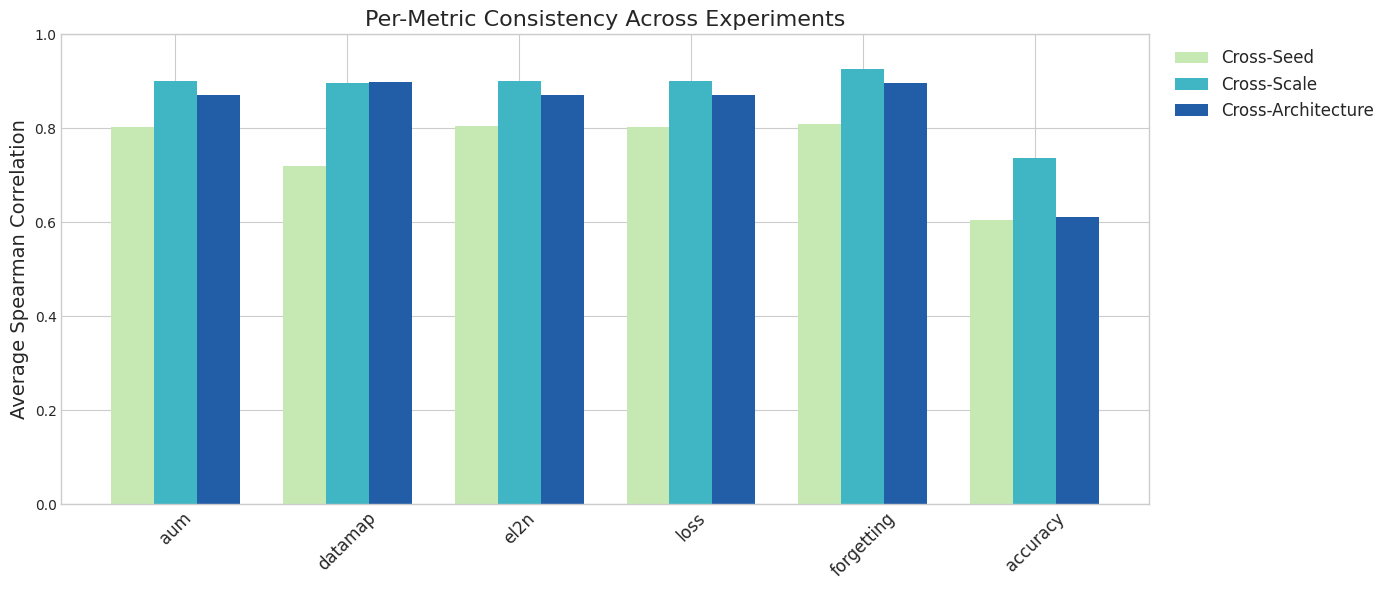


--- Analysis complete. All plots saved to '/vol/bitbucket/hrm20/fyp/analysis' directory. ---


In [13]:
def main():
    """Main function to run the entire analysis pipeline."""
    summary_path = BASE_OUTPUT_DIR / SUMMARY_FILENAME

    if not summary_path.exists():
        create_summary_file()
    
    print(f"\n--- Loading pre-processed data from '{summary_path}' ---")
    with open(summary_path, "rb") as f:
        preprocessed = pickle.load(f)
        all_ranks = preprocessed["avg_ranks"]
        cross_seed_corrs = preprocessed["cross_seed_corrs"]

    print("\n--- Generating all analysis plots ---")

    rq1_output_dir = BASE_OUTPUT_DIR / "RQ1"
    rq2_output_dir = BASE_OUTPUT_DIR / "RQ2"
    rq3_output_dir = BASE_OUTPUT_DIR / "RQ3"
    
    generate_rq2_plots(all_ranks, rq2_output_dir)

    for ds in DATASETS:
        for family in MODEL_FAMILIES:
            metrics_for_family = ALL_METRICS if family == 'roberta' else [m for m in ALL_METRICS if m != 'grand']
            
            for size in MODEL_SIZES:
                model_key = f"{family}_{size}"
                title_name = f'{model_key.replace("_", "-").title()} on {ds}'
                model_path = BASE_ARTIFACT_DIR / f"{model_key}_{ds.lower()}/"

                generate_rq1_correlation_heatmaps(model_path, title_name, rq1_output_dir, metrics_for_family, model_key, ds)
                
                seed_data = cross_seed_corrs.get(ds, {}).get(model_key, {})
                generate_rq3_plots(model_key, ds, rq3_output_dir, seed_data, metrics_for_family)

    generate_summary_plots(all_ranks, cross_seed_corrs, BASE_OUTPUT_DIR)

    print(f"\n--- Analysis complete. All plots saved to '{BASE_OUTPUT_DIR.resolve()}' directory. ---")
    
main()